In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.integrate import cumulative_trapezoid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler,MinMaxScaler

2025-05-17 23:42:05.951273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 23:42:05.964271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747510925.980605   41215 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747510925.986473   41215 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747510925.999004   41215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
bat_dict = pickle.load(open(r'./Data/bat_dict.pkl', 'rb'))

In [4]:
print(bat_dict.keys())
print(bat_dict["b1c0"].keys())
print(bat_dict["b1c0"]["summary"].keys())
print(bat_dict["b1c0"]["cycles"].keys())
print(bat_dict["b1c0"]["cycles"]["10"].keys())

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47'])
dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])
dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'

In [5]:
b1 = []
b2 = []

for bat in bat_dict.keys():
    if bat_dict[bat]["summary"]["QD"][0] < 0.9:
        b1.append(bat)
    
    for i in range(1, len(bat_dict[bat]["summary"]["QD"])):
        if bat_dict[bat]["summary"]["QD"][i] > 1.1:
            b2.append(bat)

print(b1)
print(b2)

['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45']
['b1c0', 'b1c18', 'b2c12', 'b2c44']


In [6]:
max_cycle = -np.inf
min_cycle = np.inf

for bat in bat_dict.keys():
    if bat_dict[bat]["cycle_life"] > max_cycle:
        max_cycle = bat_dict[bat]["cycle_life"][0][0]
    
    if bat_dict[bat]["cycle_life"] < min_cycle:
        min_cycle = bat_dict[bat]["cycle_life"][0][0]

print(max_cycle, min_cycle)

2237.0 148.0


In [7]:
for bat in bat_dict.keys():
    if bat in b1:
        for key in bat_dict[bat]["summary"].keys():
            bat_dict[bat]["summary"][key] = bat_dict[bat]["summary"][key][1:]

In [8]:
q_nominal = 1.1
volt_min = 2.0
volt_max = 3.5
num_volt_points = 1000
common_volt_grid = np.linspace(volt_min, volt_max, num_volt_points)
num_early_cycles = 100
seq_len = 30

In [9]:
def get_Q_V_curve_from_VIT(battery_id, cycle_num_str, bat_dict_local):
        cycle_data = bat_dict_local[battery_id]['cycles'][cycle_num_str]

        V_raw = np.array(cycle_data['V'])
        I_raw = np.array(cycle_data['I'])
        t_raw = np.array(cycle_data['t'])

        discharge_indices = np.where(I_raw < -0.01)[0]
        
        if len(discharge_indices) < 2:
            discharge_indices = np.where(I_raw > 0.01)[0]

        V_discharge = V_raw[discharge_indices]
        I_discharge = I_raw[discharge_indices]
        t_discharge = t_raw[discharge_indices]

            
        # Calculate dQ: current is in Amps, time in seconds. Q will be in Amp-seconds (Coulombs).
        # Convert to Amp-hours by dividing by 3600.
        # abs(I_discharge) because we want magnitude for capacity.
        # cumtrapz calculates cumulative integral of y (abs(I_discharge)) w.r.t x (t_discharge)
        Q_cumulative_Ah = cumulative_trapezoid(np.abs(I_discharge), t_discharge, initial=0) / 3600.0
        
        # Sort by V_discharge descending for interpolation
        sort_indices = np.argsort(V_discharge)[::-1]
        V_sorted_desc = V_discharge[sort_indices]
        Q_sorted_desc = Q_cumulative_Ah[sort_indices]
        
        # For np.interp, xp (V_for_interp) must be increasing.
        V_for_interp = V_sorted_desc[::-1]
        Q_for_interp = Q_sorted_desc[::-1]
        
        # Remove duplicate voltage points before interpolation if they cause issues, keeping the first occurrence
        unique_V_indices = np.unique(V_for_interp, return_index=True)[1]
        V_unique_for_interp = V_for_interp[unique_V_indices]
        Q_unique_for_interp = Q_for_interp[unique_V_indices]
            
        # Interpolate onto the common_voltage_grid
        # common_voltage_grid is MAX to MIN, so common_voltage_grid[::-1] is MIN to MAX (increasing).
        Q_interpolated_asc = np.interp(common_volt_grid[::-1], V_unique_for_interp, Q_unique_for_interp)
        
        # Return in the order of the original common_voltage_grid (VOLTAGE_MAX down to VOLTAGE_MIN)
        return Q_interpolated_asc[::-1]

In [10]:
def extract_early_life_features(battery_id, bat_dict_local, n_early_cycles=num_early_cycles):
    features = {}
    Q10 = get_Q_V_curve_from_VIT(battery_id, '10', bat_dict_local)
    Q100 = get_Q_V_curve_from_VIT(battery_id, '100', bat_dict_local)
    features['var_delta_Q_100_10'] = np.var(Q100 - Q10)
    
    summary = bat_dict_local[battery_id].get('summary', {})
    
    summary_cycles = np.array(summary['cycle'])
    early_indices = np.where(summary_cycles <= n_early_cycles)[0]
    if len(early_indices) < 2: return None
    
    def get_early_summary_metric(key_name):
        if key_name in summary:
            data_array = np.array(summary[key_name])[early_indices]
            if len(data_array) > 0: return data_array
        return np.array([])

    ir_early = get_early_summary_metric('IR')
    features['IR_mean_early'] = np.mean(ir_early) if len(ir_early) > 0 else np.nan
    chargetime_early = get_early_summary_metric('chargetime')
    features['chargetime_mean_early'] = np.mean(chargetime_early) if len(chargetime_early) > 0 else np.nan
    tavg_early = get_early_summary_metric('Tavg')
    features['Tavg_mean_early'] = np.mean(tavg_early) if len(tavg_early) > 0 else np.nan
    qd_early = get_early_summary_metric('QD')
    cycles_for_qd_early = summary_cycles[early_indices]

    #if len(qd_early) >= 2 and len(cycles_for_qd_early) == len(qd_early):
    #    slope, intercept, r_value, p_value, std_err = linregress(cycles_for_qd_early, qd_early)
    #    features['QD_slope_early'] = slope
    #    features['QD_var_early'] = np.var(qd_early)
    #else:
    #    features['QD_slope_early'] = np.nan
    #    features['QD_var_early'] = np.nan
    
    if any(np.isnan(val) for key, val in features.items() if key != 'var_delta_Q_100_10'): 
         if np.isnan(features.get('IR_mean_early', np.nan)) or \
            np.isnan(features.get('chargetime_mean_early', np.nan)) or \
            np.isnan(features.get('Tavg_mean_early', np.nan)):
            #np.isnan(features.get('QD_slope_early', np.nan)) or \
            #np.isnan(features.get('QD_var_early', np.nan)):
            return None
            
    return features

In [11]:
all_batteries_data_for_lstm = []
    
static_feature_names = ['var_delta_Q_100_10', 'IR_mean_early', 'chargetime_mean_early', 'Tavg_mean_early']
dynamic_feature_names = ['SOH', 'cycle_norm']

for battery_id in list(bat_dict.keys()):
    early_features = extract_early_life_features(battery_id, bat_dict)
    if early_features is None:
        print(f"Skipping {battery_id}: couldn't extract early life features")
        continue

    summary = bat_dict[battery_id].get('summary', {})

    battery_df = pd.DataFrame({
        'cycle': summary['cycle'],
        'SOH': (np.array(summary['QD']) /q_nominal) * 100
    })
    battery_df = battery_df.sort_values(by='cycle').reset_index(drop=True)

    if len(battery_df) < seq_len + 1:
        print(f"skipping {battery_id}: not enough data ({len(battery_df)}) for sequence length")
        continue

    static_features_values = [early_features[name] for name in static_feature_names]
    all_batteries_data_for_lstm.append({
        'id': battery_id,
        'static_features': np.array(static_features_values),
        'dynamic_df': battery_df 
    })

In [12]:
train_batteries_data, test_batteries_data = train_test_split(all_batteries_data_for_lstm, test_size=0.25, random_state=987123)

In [13]:
static_features_train_list = [b['static_features'] for b in train_batteries_data]
static_scaler = StandardScaler()
static_scaler.fit(np.array(static_features_train_list))

all_train_soh = np.concatenate([b['dynamic_df']['SOH'].values for b in train_batteries_data]).reshape(-1, 1)
soh_scaler = MinMaxScaler(feature_range=(0, 1))
soh_scaler.fit(all_train_soh)

all_train_cycles = np.concatenate([b['dynamic_df']['cycle'].values for b in train_batteries_data]).reshape(-1, 1)
cycle_scaler = MinMaxScaler(feature_range=(0, 1))
cycle_scaler.fit(all_train_cycles)

MinMaxScaler()

In [14]:
def create_lstm_sequences(batteries_data, static_scaler, soh_scaler, cycle_scaler, sequence_length):
    X_seq, y_seq = [], []
    num_static_feats = len(static_feature_names)
    # num_dynamic_feats = 2 (SOH_scaled, cycle_scaled)
        
    for battery_data in batteries_data:
        static_feats_scaled = static_scaler.transform(battery_data['static_features'].reshape(1, -1))[0]

        df = battery_data['dynamic_df'].copy()
        df['SOH_scaled'] = soh_scaler.transform(df[['SOH']])
        df['cycle_scaled'] = cycle_scaler.transform(df[['cycle']])

        for i in range(len(df) - sequence_length):
            dynamic_part = df[['SOH_scaled', 'cycle_scaled']].iloc[i : i + sequence_length].values

            # tile static feats to match sequence length and then concat
            static_part_tiled = np.tile(static_feats_scaled, (sequence_length, 1))

            sequence = np.concatenate((dynamic_part, static_part_tiled), axis=1)
            X_seq.append(sequence)
            y_seq.append(df['SOH_scaled'].iloc[i + sequence_length]) # target is next SOH_scaled

    return np.array(X_seq), np.array(y_seq)

In [15]:
X_train, y_train = create_lstm_sequences(train_batteries_data, static_scaler, soh_scaler, cycle_scaler, seq_len)
X_test, y_test = create_lstm_sequences(test_batteries_data, static_scaler, soh_scaler, cycle_scaler, seq_len)

print(f"Training sequences: X_train shape {X_train.shape}, y_train shape {y_train.shape}")

/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/

Training sequences: X_train shape (42293, 30, 6), y_train shape (42293,)


/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [16]:
# num_features_per_step = SOH_scaled + cycle_scaled + num_static_features
num_features_per_step = 2 + len(static_feature_names) 

model = Sequential([
    Input(shape=(seq_len, num_features_per_step)),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1) # predicts next SOH_scaled
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

I0000 00:00:1747510944.825249   41215 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1401 MB memory:  -> device: 0, name: NVIDIA GeForce MX550, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 32)         │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,857 (54.13 KB)

 Trainable params: 13,857 (54.13 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
history = None

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/50


I0000 00:00:1747510947.026260   41280 service.cc:152] XLA service 0x5613e0d4c580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747510947.026288   41280 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX550, Compute Capability 7.5
2025-05-17 23:42:27.074196: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747510947.428049   41280 cuda_dnn.cc:529] Loaded cuDNN version 90701


  27/1322 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0227  

I0000 00:00:1747510949.382621   41280 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1322/1322 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0022 - val_loss: 2.2033e-04
Epoch 2/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.9650e-04 - val_loss: 2.0568e-04
Epoch 3/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.1024e-04 - val_loss: 1.6305e-04
Epoch 4/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.0113e-04 - val_loss: 1.5320e-04
Epoch 5/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.1894e-05 - val_loss: 1.2162e-04
Epoch 6/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 7.1580e-05 - val_loss: 1.3609e-04
Epoch 7/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 7.9739e-05 - val_loss: 1.2762e-04
Epoch 8/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 7.5187e-05 - val_loss: 8.6946e-05
Epoch 9/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.5037e-05 - val_loss: 8.8200e-05
Epoch 10/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 7.9558e-05 - val_loss: 8.3321e-05
Epoch 11/50
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/ste

451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
LSTM Test Set Performance (on one-step ahead predictions):
  R^2 Score: 0.9183
  MAE: 1.1352 (SOH %)
  RMSE: 1.4683 (SOH %)


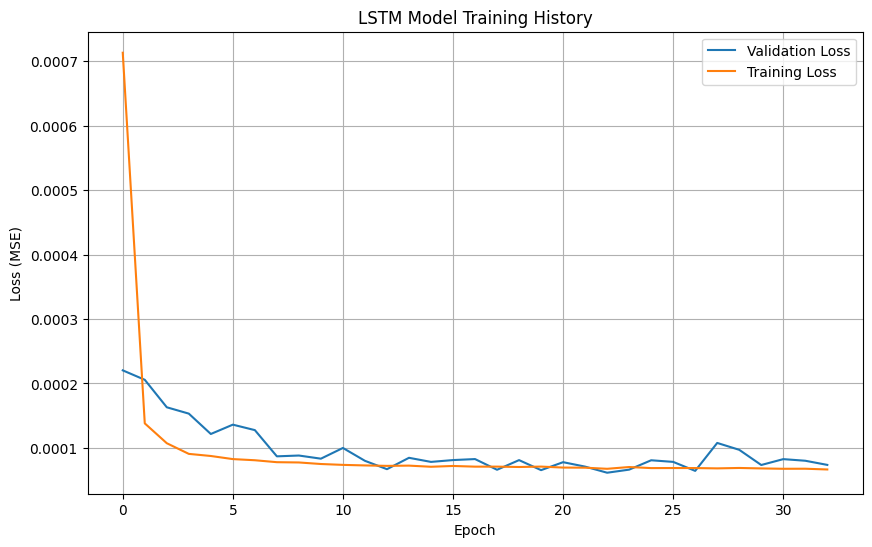

In [18]:
y_pred_scaled_test = model.predict(X_test)
y_pred_test = soh_scaler.inverse_transform(y_pred_scaled_test) # Inverse scale SOH
y_actual_test = soh_scaler.inverse_transform(y_test.reshape(-1,1))

r2_lstm = r2_score(y_actual_test, y_pred_test)
mae_lstm = mean_absolute_error(y_actual_test, y_pred_test)
rmse_lstm = np.sqrt(mean_squared_error(y_actual_test, y_pred_test))
print(f"LSTM Test Set Performance (on one-step ahead predictions):")
print(f"  R^2 Score: {r2_lstm:.4f}")
print(f"  MAE: {mae_lstm:.4f} (SOH %)")
print(f"  RMSE: {rmse_lstm:.4f} (SOH %)")

plt.figure(figsize=(10,6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


Generating full SOH curve prediction for test battery: b1c7


/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


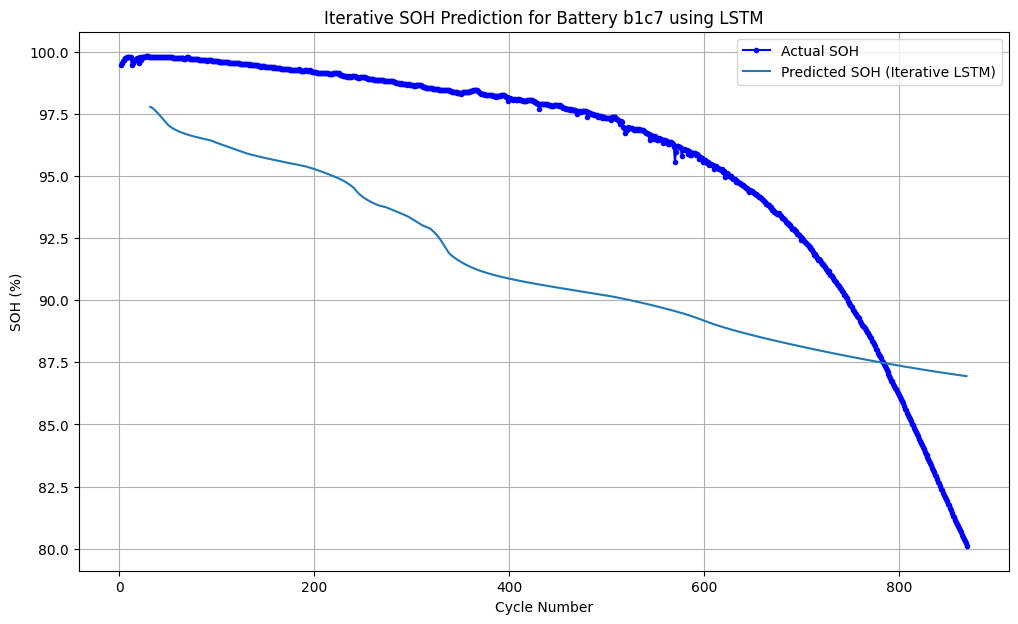

In [19]:
battery_to_plot_data = test_batteries_data[0] #first battery from test set to plot
print(f"\nGenerating full SOH curve prediction for test battery: {battery_to_plot_data['id']}")

#prep initial sequence
df_plot = battery_to_plot_data['dynamic_df'].copy()
static_feats_plot_scaled = static_scaler.transform(battery_to_plot_data['static_features'].reshape(1, -1))[0]
        
df_plot['SOH_scaled'] = soh_scaler.transform(df_plot[['SOH']])
df_plot['cycle_scaled'] = cycle_scaler.transform(df_plot[['cycle']])
actual_soh_full = df_plot['SOH'].values
actual_cycles_full = df_plot['cycle'].values

#initial input sequence from actual data
current_sequence_dynamic_part = df_plot[['SOH_scaled', 'cycle_scaled']].iloc[0:seq_len].values
current_static_part_tiled = np.tile(static_feats_plot_scaled, (seq_len, 1))
current_input_sequence = np.concatenate((current_sequence_dynamic_part, current_static_part_tiled), axis=1).reshape(1, seq_len, num_features_per_step)
predicted_soh_scaled_iterative = []

#start predicting
for i in range(seq_len, len(df_plot)):
    next_soh_scaled_pred = model.predict(current_input_sequence, verbose=0)[0,0]
    predicted_soh_scaled_iterative.append(next_soh_scaled_pred)
    
    #slide window
    # actual, we don't predict cycle numbers
    next_cycle_scaled = df_plot['cycle_scaled'].iloc[i] #cycle number for the point we just predicted SOH for
    
    new_dynamic_row = np.array([[next_soh_scaled_pred, next_cycle_scaled]])
    
    current_sequence_dynamic_part = np.append(current_sequence_dynamic_part[1:], new_dynamic_row, axis=0)
    
    current_input_sequence = np.concatenate((current_sequence_dynamic_part, current_static_part_tiled), axis=1).reshape(1, seq_len, num_features_per_step)


predicted_soh_iterative = soh_scaler.inverse_transform(np.array(predicted_soh_scaled_iterative).reshape(-1,1))
plt.figure(figsize=(12,7))
plt.plot(actual_cycles_full, actual_soh_full, 'bo-', label='Actual SOH', markersize=3)
plt.plot(actual_cycles_full[seq_len:], predicted_soh_iterative, label='Predicted SOH (Iterative LSTM)', markersize=3)
plt.title(f'Iterative SOH Prediction for Battery {battery_to_plot_data["id"]} using LSTM')
plt.xlabel('Cycle Number')
plt.ylabel('SOH (%)')
plt.legend()
plt.grid(True)
plt.show()